In [4]:
import keras
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import SVG
from IPython.display import display

import random

In [12]:
size = 100
def appendSize():
    return str(size) + 'x' + str(size)

# Load image data
imgdat_glass = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_glass_' + appendSize() + '.npy')
imgdat_paper = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_paper_' + appendSize() + '.npy')
imgdat_cardboard = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_cardboard_' + appendSize() + '.npy')
imgdat_plastic = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_plastic_' + appendSize() + '.npy')
imgdat_metal = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_metal_' + appendSize() + '.npy')
imgdat_trash = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_trash_' + appendSize() + '.npy')

# Make sure the data loaded correctly
print(imgdat_glass.shape)
print(imgdat_paper.shape)
print(imgdat_cardboard.shape)
print(imgdat_plastic.shape)
print(imgdat_metal.shape)
print(imgdat_trash.shape)

# Load in the labels and convert to one-hot encoding
with open('/nfshome/sandbox/TrashNet-Dataset/labels.csv', 'r', encoding = 'utf-8') as f:
    labels = f.read().split(',')
Y = keras.utils.to_categorical(labels)

print(Y.shape)

(501, 100, 100, 3)
(594, 100, 100, 3)
(403, 100, 100, 3)
(482, 100, 100, 3)
(410, 100, 100, 3)
(137, 100, 100, 3)
(2527, 6)


In [58]:
# Concatenate image data for input to network
#X = np.concatenate((imgdat_glass, imgdat_paper, imgdat_cardboard, 
#                   imgdat_plastic, imgdat_metal, imgdat_trash))


# Split labels up by category
imgdat_lens = [imgdat_glass.shape[0], imgdat_paper.shape[0], imgdat_cardboard.shape[0],
               imgdat_plastic.shape[0], imgdat_metal.shape[0], imgdat_trash.shape[0]]
Y_categories = []
index_start = 0
for imgdat_len in imgdat_lens:
    index_end = index_start + imgdat_len
    Y_categories = Y_categories + [Y[index_start : index_end]]
    index_start = index_end

# Shuffle all image data
imgdat_glass = imgdat_glass[np.random.permutation(len(imgdat_glass))]
imgdat_paper = imgdat_paper[np.random.permutation(len(imgdat_paper))]
imgdat_cardboard = imgdat_cardboard[np.random.permutation(len(imgdat_cardboard))]
imgdat_plastic = imgdat_plastic[np.random.permutation(len(imgdat_plastic))]
imgdat_metal = imgdat_metal[np.random.permutation(len(imgdat_metal))]
imgdat_trash = imgdat_trash[np.random.permutation(len(imgdat_trash))]

# Split image categories into training and testing sets
def getHalfLen(img_set):
    return int(len(img_set) / 2)

training_glass = imgdat_glass[ : getHalfLen(imgdat_glass)]
training_glass_labels = Y_categories[0][ : getHalfLen(Y_categories[0])]
training_paper = imgdat_paper[ : getHalfLen(imgdat_paper)]
training_paper_labels = Y_categories[1][ : getHalfLen(Y_categories[1])]
training_cardboard = imgdat_cardboard[ : getHalfLen(imgdat_cardboard)]
training_cardboard_labels = Y_categories[2][ : getHalfLen(Y_categories[2])]
training_plastic = imgdat_plastic[ : getHalfLen(imgdat_plastic)]
training_plastic_labels = Y_categories[3][ : getHalfLen(Y_categories[3])]
training_metal = imgdat_metal[ : getHalfLen(imgdat_metal)]
training_metal_labels = Y_categories[4][ : getHalfLen(Y_categories[4])]
training_trash = imgdat_trash[ : getHalfLen(imgdat_trash)]
training_trash_labels = Y_categories[5][ : getHalfLen(Y_categories[5])]

testing_glass = imgdat_glass[getHalfLen(imgdat_glass) : ]
testing_glass_labels = Y_categories[0][getHalfLen(Y_categories[0]) : ]
testing_paper = imgdat_paper[getHalfLen(imgdat_paper) : ]
testing_paper_labels = Y_categories[1][getHalfLen(Y_categories[1]) : ]
testing_cardboard = imgdat_cardboard[getHalfLen(imgdat_cardboard) : ]
testing_cardboard_labels = Y_categories[2][getHalfLen(Y_categories[2]) : ]
testing_plastic = imgdat_plastic[getHalfLen(imgdat_plastic) : ]
testing_plastic_labels = Y_categories[3][getHalfLen(Y_categories[3]) : ]
testing_metal = imgdat_metal[getHalfLen(imgdat_metal) : ]
testing_metal_labels = Y_categories[4][getHalfLen(Y_categories[4]) : ]
testing_trash = imgdat_trash[getHalfLen(imgdat_trash) : ]
testing_trash_labels = Y_categories[5][getHalfLen(Y_categories[5]) : ]

# Concatenate into training and testing sets
X_train = np.concatenate((training_glass, training_paper, training_cardboard,
                          training_plastic, training_metal, training_trash))
Y_train = np.concatenate((training_glass_labels, training_paper_labels, training_cardboard_labels,
                          training_plastic_labels, training_metal_labels, training_trash_labels))

X_test = np.concatenate((testing_glass, testing_paper, testing_cardboard,
                         testing_plastic, testing_metal, testing_trash))
Y_test = np.concatenate((testing_glass_labels, testing_paper_labels, testing_cardboard_labels,
                         testing_plastic_labels, testing_metal_labels, testing_trash_labels))

# Shuffle training and testing sets
permute = np.random.permutation(len(X_train))
X_train = X_train[permute]
Y_train = Y_train[permute]

permute = np.random.permutation(len(X_test))
X_test = X_test[permute]
Y_test = Y_test[permute]

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)
print('Combined X: ', X_train.shape[0] + X_test.shape[0])

X_train shape:  (1262, 100, 100, 3)
Y_train shape:  (1262, 6)
X_test shape:  (1265, 100, 100, 3)
Y_test shape:  (1265, 6)
Combined X:  2527


In [59]:
# Mean-center all image data
#X = (X - X.mean()) / X.std()
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [ ]:
# Now we'll split the input and labels into groups again.
# We'll shuffle these categories separately so that we can ensure both
# training and testing sets have some images from each category.

imgdat_lens = [imgdat_glass.shape[0], imgdat_paper.shape[0], imgdat_cardboard.shape[0],
               imgdat_plastic.shape[0], imgdat_metal.shape[0], imgdat_trash.shape[0]]
X_categories = []
Y_categories = []

index_start = 0
for imgdat_len in imgdat_lens:
    index_end = index_start + imgdat_len
    X_categories = X_categories + [X[index_start : index_end]]
    Y_categories = Y_categories + [Y[index_start : index_end]]
    index_start = index_end
    
X_train = np.array([])
X_test = np.array([])
Y_train = np.array([])
Y_test = np.array([])

X_train.shape = (0, size, size, 3)
X_test.shape = (0, size, size, 3)
Y_train.shape = (0, 6)
Y_test.shape = (0, 6)

# Shuffle both X and Y
for i in range(len(X_categories)):
    for j in range(X_categories[i].shape[0]):
        randIndex = random.randint(0, X_categories[i].shape[0] - 1)

        # Swap X
        tempX = X_categories[i][j]
        X_categories[i][j] = X_categories[i][randIndex]
        X_categories[i][randIndex] = tempX

        # Don't actually have to swap Y since we'd just be shuffling labels in each
        # category, meaning we'd have essentially the same arrangement we started with.
        # Swap Y
        #tempY = Y_categories[i][j]
        #Y_categories[i][j] = Y_categories[i][randIndex]
        #Y_categories[i][randIndex] = tempY
    
    # Split the shuffled categories equally into training and testing sets
    half = int(X_categories[i].shape[0] / 2)
    X_train = np.concatenate((X_train, X_categories[i][0 : half]))
    X_test = np.concatenate((X_test, X_categories[i][half : ]))
    Y_train = np.concatenate((Y_train, Y_categories[i][0 : half]))
    Y_test = np.concatenate((Y_test, Y_categories[i][half : ]))
    
print("X shape: " + str(X.shape))
print("Y shape: " + str(Y.shape))
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_train shape: " + str(Y_train.shape))
print("Y_test shape: " + str(Y_test.shape))
print("X_train + X_test size: " + str(X_train.shape[0] + X_test.shape[0]))
print("Y_train + Y_test size: " + str(Y_train.shape[0] + Y_test.shape[0]))
'''

In [ ]:
model = keras.Sequential()

# Bottleneck to keep parameters low
model.add(keras.layers.Conv2D(24, kernel_size = (1, 1), # squeeze
                              activation = 'relu',
                              bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              kernel_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              input_shape = [size, size, 3]))

model.add(keras.layers.Conv2D(24, kernel_size = (3, 3), # map 
                              strides = (2, 2),
                              activation = 'relu',
                              bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              kernel_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None)))

model.add(keras.layers.Conv2D(32, kernel_size = (1, 1), # expand
                             activation = 'relu',
                             bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None), 
                             kernel_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None)))
model.add(keras.layers.BatchNormalization(momentum = 0.99))

model.add(keras.layers.SpatialDropout2D(rate = 0.25))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(Y.shape[1] * 2, activation = 'tanh'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(Y.shape[1], activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.0001, amsgrad = True),
             metrics = ['accuracy'])

model.summary()

model = keras.Sequential()

#model.add(keras.layers.Conv2D(32, kernel_size = (1, 1),
#                             activation = 'relu',
#                             input_shape = [size, size, 3]))
#model.add(keras.layers.SpatialDropout2D(rate = 0.25))
model.add(keras.layers.Conv2D(32, kernel_size = (3, 3),
                             strides = (2, 2),
                             activation = 'relu',
                             input_shape = [size, size, 3]))
model.add(keras.layers.SpatialDropout2D(rate = 0.25))
#model.add(keras.layers.Conv2D(64, kernel_size = (1, 1),
#                             activation = 'relu'))
#model.add(keras.layers.SpatialDropout2D(rate = 0.25))
model.add(keras.layers.normalization.BatchNormalization(momentum = 0.99))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(Y.shape[1] * 4, activation = 'tanh'))
model.add(keras.layers.Dense(Y.shape[1] * 3, activation = 'tanh'))
model.add(keras.layers.Dense(Y.shape[1] * 2, activation = 'tanh'))
model.add(keras.layers.Dense(Y.shape[1], activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.0001, amsgrad = True),
              metrics = ['accuracy'])
model.summary()

net_in = keras.layers.Input(shape = [size, size, 3])

# Send input to two different convolving layers: one vertical and one horizontal
conv_horiz = keras.layers.Conv2D(16, kernel_size = (4, 2), activation = 'relu')(net_in)
conv_verti = keras.layers.Conv2D(16, kernel_size = (2, 4), activation = 'relu')(net_in)

# Normalize
bNorm_horiz = keras.layers.normalization.BatchNormalization()(conv_horiz)
bNorm_verti = keras.layers.normalization.BatchNormalization()(conv_verti)

# Convolve into square shape
conv_horiz_reshaped = keras.layers.Conv2D(32, kernel_size = (2, 4), activation = 'relu')(bNorm_horiz)
conv_verti_reshaped = keras.layers.Conv2D(32, kernel_size = (4, 2), activation = 'relu')(bNorm_verti)

# Normalize again
bNorm_horiz_reshaped = keras.layers.normalization.BatchNormalization()(conv_horiz_reshaped)
bNorm_verti_reshaped = keras.layers.normalization.BatchNormalization()(conv_verti_reshaped)

# Dense, merge, and dropout
merged = keras.layers.concatenate([bNorm_horiz_reshaped, bNorm_verti_reshaped])
spDropout = keras.layers.SpatialDropout2D(0.5)(merged)

# Max pooling and flatten
pooled = keras.layers.MaxPooling2D(2, 2)(spDropout)
flat = keras.layers.Flatten()(pooled)

# Dense layers
#dense = keras.layers.Dense(Y.shape[1] * 3, activation = 'tanh')(flat)

# Dropout
#dropout = keras.layers.Dropout(0.25)(flat)

# Output
net_out = keras.layers.Dense(Y.shape[1], activation = 'softmax')(flat)

# Create model and compile
model = keras.Model(net_in, net_out)
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.001, amsgrad = True),
             metrics = ['accuracy'])
model.summary()

In [79]:
img_in = keras.layers.Input(shape = [size, size, 3])

conv_large = keras.layers.Conv2D(24, kernel_size = (5,  5), activation = 'relu')(img_in)
conv_small = keras.layers.Conv2D(24, kernel_size = (2, 2), activation = 'relu')(img_in)

spDropout_large = keras.layers.SpatialDropout2D(0.5)(conv_large)
spDropout_small = keras.layers.SpatialDropout2D(0.5)(conv_small)

bNorm_large = keras.layers.normalization.BatchNormalization()(spDropout_large)
bNorm_small = keras.layers.normalization.BatchNormalization()(spDropout_small)

pool_large = keras.layers.MaxPooling2D(2, 2)(bNorm_large)
pool_small = keras.layers.MaxPooling2D(2, 2)(bNorm_small)

flat_large = keras.layers.Flatten()(pool_large)
flat_small = keras.layers.Flatten()(pool_small)

dense_large = keras.layers.Dense(Y.shape[1], activation = 'tanh')(flat_large)
dense_small = keras.layers.Dense(Y.shape[1], activation = 'tanh')(flat_small)

combined = keras.layers.concatenate([dense_large, dense_small])
#dense = keras.layers.Dense(Y.shape[1] * 2, activation = 'tanh')(combined)
#dropout = keras.layers.Dropout(0.25)(dense)
net_out = keras.layers.Dense(Y.shape[1], activation = 'softmax')(combined)

model = keras.Model(img_in, net_out)
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.0001, amsgrad = True),
             metrics = ['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 96, 96, 24)   1824        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 99, 99, 24)   312         input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 96, 96, 24)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
spatial_dr

In [ ]:
SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

In [78]:
history = model.fit(X_train, Y_train, batch_size = 200, 
                    epochs = 10, verbose = 0, validation_split = 0.25, 
                    callbacks = [TQDMNotebookCallback()])
print('Accuracy: ', model.evaluate(X_test, Y_test)[1] * 100.0, '%')

KeyboardInterrupt: 

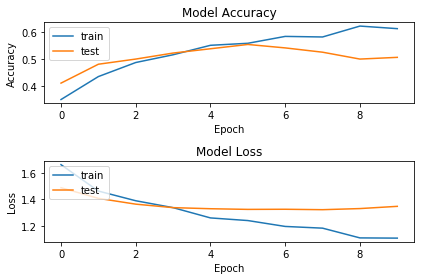

In [36]:
plt.figure(1)

# Accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

# Loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

plt.tight_layout()
plt.show()

In [144]:
model = keras.models.load_model('model.model')
model.load_weights('model.weights')

In [145]:
history2 = model.fit(X_train, Y_train, batch_size = 200, 
                    epochs = 100, verbose = 0, validation_split = 0.25, 
                    callbacks = [TQDMNotebookCallback()])
print('Accuracy: ', model.evaluate(X, Y)[1] * 100.0, '%')

2527/2527 [==============================] - 19s 8ms/step
Accuracy:  59.200633161852004 %


In [138]:
model.save_weights('model_4.weights')
model.save('model_4.model')

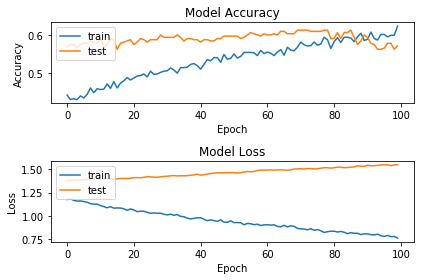

In [150]:
plt.figure(1)

# Accuracy
plt.subplot(211)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

# Loss
plt.subplot(212)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

plt.tight_layout()
plt.show()

In [37]:
preds = model.predict(X_test)

[13.815882  18.93787    5.857979  46.598873  11.526981   3.2624211]
[0. 1. 0. 0. 0. 0.]


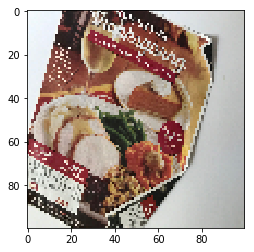

In [68]:
img = 6
np.set_printoptions(suppress = True)
print(preds[img] * 100.0)
print(Y_test[img])

plt.imshow(keras.preprocessing.image.array_to_img(X_test[img, :, :, :]))
plt.show()

#for a in Y_train:
#    print(a)

In [42]:
def getIndexOfHighestConfidence(pred):
    highestConfidenceIndex = 0
    for i in range(len(pred)):
        if pred[i] > pred[highestConfidenceIndex]:
            highestConfidenceIndex = i
    return highestConfidenceIndex

def getIndexOfClassification(test):
    classIndex = 0
    for i in range(len(test)):
        if test[i] == 1:
            classIndex = i
            break
    return classIndex

numCorrect = 0
for i in range(len(preds)):
    if getIndexOfHighestConfidence(preds[i]) == getIndexOfClassification(Y_test[i]):
        numCorrect = numCorrect + 1

percentCorrect = numCorrect / len(preds)
print(percentCorrect * 100.0)

71.699604743083
